Wrote by Yujing YANG

In [4]:
import os
import glob
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance
plt.rcParams['figure.dpi'] = 100

# get current working directory

In [7]:
# find current working directoy
cwd_path = Path().absolute() 
data_root = cwd_path.parent.parent / "data"
experiment1 = "cerebellum"
experiment2 = "CellCulture"
res = "200kb"
chrom_list = [f"chr{x}" for x in range(1, 20)]
chrom_list.append("chrX")

# Read in meta information

In [16]:
# read all celltypes information in cerebellum
leidens1 = ["0+1", "2", "4", "6+11", "7"]
cell_types1 = ["Granule", "Bergmann", "MLI1", "Purkinje", "MLI2+PLI"]

df_dict = {}
# read cerebellem
for ld, ct in zip(leidens1, cell_types1):
    df_dict[ct] = pd.read_csv(str(data_root / experiment1 / "IF_ensemble" / f"IF_markers_median_200kb_binned_cerebellum_leiden_{ld}.csv"))
    
# read all celltypes information of cell culture
cell_types2 = ["E14", "NMuMG"]
for ct in cell_types2:
    # start a container for dataframes
    file = glob.glob(str(data_root / experiment2 / "IF_ensemble"/ f"*{res}*{ct}.csv"))[0]
    # read in all information
    df_dict[ct] = pd.read_csv(file)
    
# read in selected marker peak calling data
final_df1 = pd.read_csv(os.path.join(data_root, experiment1, "peak_detection/110822_all_markers_lncRNA_all_peaks.csv"))
final_df2 = pd.read_csv(os.path.join(data_root, experiment2, "peak_detection/110822_all_markers_lncRNA_all_peaks.csv"))
final_df = pd.concat([final_df1, final_df2])

In [17]:
# get mutual bins first
cerebellum_bins = df_dict["Bergmann"]["200kb name"].values
cellculture_bins = df_dict["E14"]["200kb name"].values
common_bins = set(cerebellum_bins) & set(cellculture_bins)
# get the data only in common bins
final_df = final_df[final_df["200kb name"].isin(common_bins)]

# get the data organized in common bins for df_dict
order = df_dict["Granule"][["200kb name"]]
for ct in cell_types2:
    df_dict[ct] = order.merge(df_dict[ct],  how  = "left")

In [18]:
# check if the peak dataframe have all cell types including E14 and NMuMG
final_df["celltype"].value_counts()

Bergmann_peak    12562
Granule_peak     12562
MLI1_peak        12562
MLI2+PLI_peak    12562
Purkinje_peak    12562
E14_peak         12562
NMuMG_peak       12562
Name: celltype, dtype: int64

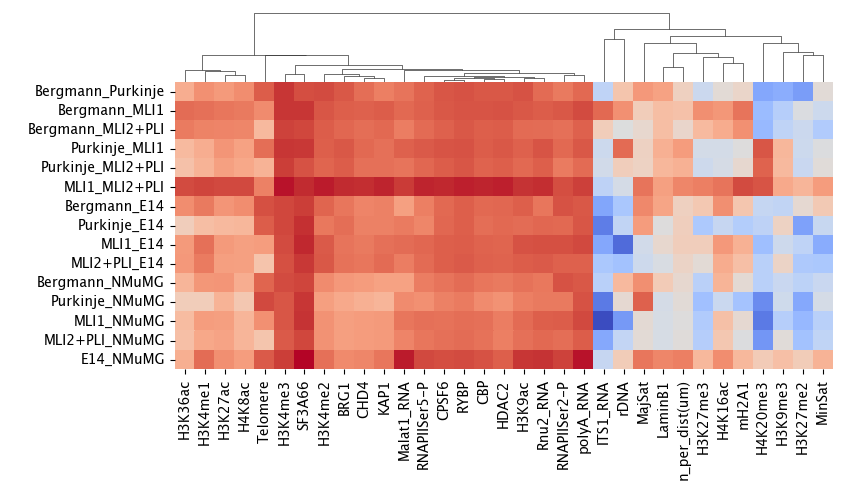

In [21]:
# using the set of two cell types to calculate correlation
# test of correlation matrix index
import scipy.stats
# remove markers that not expressed in other cell types
# markers included in the analysis
select_markers = ['BRG1', 'CBP', 'CHD4', 'CPSF6', 'H3K27ac', 'H3K27me2', 'H3K27me3', 'H3K36ac', 'H3K4me1',
       'H3K4me2', 'H3K4me3', 'H3K9ac', 'H3K9me3', 'H4K16ac', 'H4K20me3',
       'H4K8ac', 'HDAC2', 'ITS1_RNA', 'KAP1', 'LaminB1', 'MajSat',
       'Malat1_RNA', 'MinSat', 'RNAPIISer2-P', 'RNAPIISer5-P', 'RYBP',
       'Rnu2_RNA', 'SF3A66', 'Telomere', 'mH2A1', 'n_per_dist(um)',
       'polyA_RNA', 'rDNA']

select_cells = ['Bergmann', 'Purkinje', 'MLI1', 'MLI2+PLI', 'E14', 'NMuMG']
scores = []
for marker in select_markers:
    sdf = final_df[["200kb name", "celltype", marker]].pivot(index='200kb name', columns='celltype', values= marker)
    df = sdf
    s = []
    # using the union of two cell types
    for i in range(len(select_cells)):
        for j in range(i + 1, len(select_cells)):
            ct1 = select_cells[i]
            ct2 = select_cells[j]
            peak1_id = f"{ct1}_peak"
            peak2_id = f"{ct2}_peak"
            comb_bins = df[(df[peak1_id] == 1) |  (df[peak2_id] == 1)].index

            x1 = df_dict[ct1][df_dict[ct1]["200kb name"].isin(comb_bins)][marker].values
            x2 = df_dict[ct2][df_dict[ct2]["200kb name"].isin(comb_bins)][marker].values
            
            # calculate correlation
            s.append(scipy.stats.pearsonr(x1, x2)[0])
    scores.append(s)
    
scores = np.array(scores)

# y axes
y_names = []
for i in range(len(select_cells)):
    for j in range(i + 1, len(select_cells)):
        ct1 = select_cells[i]
        ct2 = select_cells[j]
        y_names.append(f"{ct1}_{ct2}")

# cluster by changing pattern
row_idx = [0,1,2,5,6,9,3,7,10,12,4,8,11,13,14]
g = sns.clustermap(scores.T[row_idx], cmap = "coolwarm", yticklabels = np.array(y_names)[row_idx], xticklabels = np.array(select_markers), figsize = (10, 5), 
                   row_cluster=False, cbar_kws={'shrink': 0.5}, cbar_pos = None)
g.ax_heatmap.yaxis.set_ticks_position("left")